In [139]:
from calendar import c
import time
import json
import pandas as pd
import numpy as np
import river
import sys
from sklearn.metrics import mean_absolute_percentage_error
from river import preprocessing, tree, metrics

from kafka import KafkaConsumer
import time
from kafka import KafkaConsumer
import json
import pandas as pd
import river
import time
from river.tree import HoeffdingTreeClassifier
from river.neighbors import KNNClassifier
from river.stream import iter_pandas
from river import metrics
from river import utils

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [140]:
if __name__ == '__main__':

    name = sys.argv[1]
    topic_name = 'project'
    consumer = KafkaConsumer(topic_name, bootstrap_servers="localhost:9092",value_deserializer=lambda m: json.loads(m.decode('utf-8')))#json.dumps(m).decode('utf8'))
    col = ['open_time', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'nb_trades',
        'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']
    model = (
            river.preprocessing.StandardScaler() |
            river.tree.HoeffdingTreeRegressor(
                grace_period=200,
                leaf_prediction='adaptive',
                model_selector_decay=0.9
            )
        )

    for i in consumer:
        res = json.loads(json.dumps(i.value))
        df = pd.DataFrame(res, columns=col)
        for i in col:
            df[i] = df[i].astype(float)
        df['open_time'] = df['open_time'].apply(lambda x: datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))
        df = df.set_index('open_time')
        
        print()
        print('----------------------------------------------------------------------')

KeyboardInterrupt: 

In [ ]:
def print_progress(y, y_pred, date, sample_id, training_time, testing_time):
    print(f'Samples processed: {sample_id}')
    print(f'Prevision at {date}')
    print(f'Predicted value : {y_pred:.2f}')
    print(f'Real value : {y}')
    print("total train time:" , training_time)
    print("total testing time:",testing_time)

def evaluate(stream, model):

    list_of_trainings = []
    list_of_testings = []
    list_y = []
    list_ypred = []

    training_time = 0
    testing_time = 0
    metric = river.metrics.MAE()    
    metric_mape = river.metrics.SMAPE()

    for i, (x, y) in enumerate(stream):
        # Predict
        start = time.time()
        y_pred = model.predict_one(x)
        end = time.time()
        testing_time = end-start
        list_of_testings.append(testing_time)
        
        # Learn (train)
        start = time.time()
        list_y.append(y)
        list_ypred.append(y_pred)
        m = metric.update(y_pred, y).get()
        m2 = metric_mape.update(y_pred, y).get()
        model.learn_one(x, y)
        end = time.time()
        training_time =  end-start
        list_of_trainings.append(training_time)
        
    # Update metrics and results
    print_progress(y, y_pred, df.iloc[-1].name,i,sum(list_of_trainings),sum(list_of_testings))
    return y, y_pred, m, m2

In [151]:
#df.to_csv('bitcoin.csv', index=False)

In [152]:
df = pd.read_csv('bitcoin.csv')

In [153]:
df.shape

(1000, 11)

In [154]:
df = df[650:]

In [156]:
df[100:351]

,open,high,low,close,volume,close_time,quote_asset_volume,nb_trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
750,18146.06,18153.42,18139.21,18140.00,178.36836,1.673515e+12,3.236541e+06,4622.0,81.86657,1.485541e+06,0.0
751,18140.00,18143.27,18131.05,18132.82,190.83521,1.673515e+12,3.461090e+06,4222.0,66.66411,1.209112e+06,0.0
752,18132.82,18141.99,18132.42,18141.48,153.86115,1.673515e+12,2.790766e+06,3293.0,105.67036,1.916669e+06,0.0
753,18140.78,18141.74,18136.35,18138.75,81.97832,1.673515e+12,1.487040e+06,2659.0,37.01909,6.715155e+05,0.0
754,18138.75,18139.82,18134.03,18135.56,63.55415,1.673515e+12,1.152640e+06,2350.0,22.79419,4.134074e+05,0.0
...,...,...,...,...,...,...,...,...,...,...,...
995,18252.20,18257.05,18246.76,18247.43,206.11351,1.673530e+12,3.761795e+06,6230.0,90.12643,1.644928e+06,0.0
996,18247.43,18248.00,18215.65,18220.09,601.06591,1.673530e+12,1.095738e+07,11806.0,265.53206,4.840804e+06,0.0
997,18220.09,18228.15,18206.40,18211.76,426.57337,1.673530e+12,7.770362e+06,11332.0,206.95374,3.769865e+06,0.0
998,18211.77,18220.67,18194.96,18209.88,504.83179,1.673530e+12,9.191151e+06,10650.0,217.93879,3.968019e+06,0.0


In [157]:
list_y = []
list_ypred = []
for i in range(250):
    y = df[i:100+i].close
    X = df[i:100+i].drop(columns = 'close')
    y, y_pred, m, m2 = evaluate(stream=iter_pandas(X=X, y=y),
                      model=model)
    list_y.append(y)
    list_ypred.append(y_pred)

Samples processed: 99
Prevision at 999
Predicted value : 18127.01
Real value : 18146.06
total train time: 0.04438495635986328
total testing time: 0.0071599483489990234
Samples processed: 99
Prevision at 999
Predicted value : 18127.05
Real value : 18140.0
total train time: 0.08887839317321777
total testing time: 0.006800174713134766
Samples processed: 99
Prevision at 999
Predicted value : 18126.98
Real value : 18132.82
total train time: 0.027004718780517578
total testing time: 0.004430055618286133
Samples processed: 99
Prevision at 999
Predicted value : 18126.87
Real value : 18141.48
total train time: 0.0680093765258789
total testing time: 0.004251956939697266
Samples processed: 99
Prevision at 999
Predicted value : 18126.80
Real value : 18138.75
total train time: 0.031450748443603516
total testing time: 0.0053577423095703125
Samples processed: 99
Prevision at 999
Predicted value : 18126.73
Real value : 18135.56
total train time: 0.0758981704711914
total testing time: 0.0049893856048583

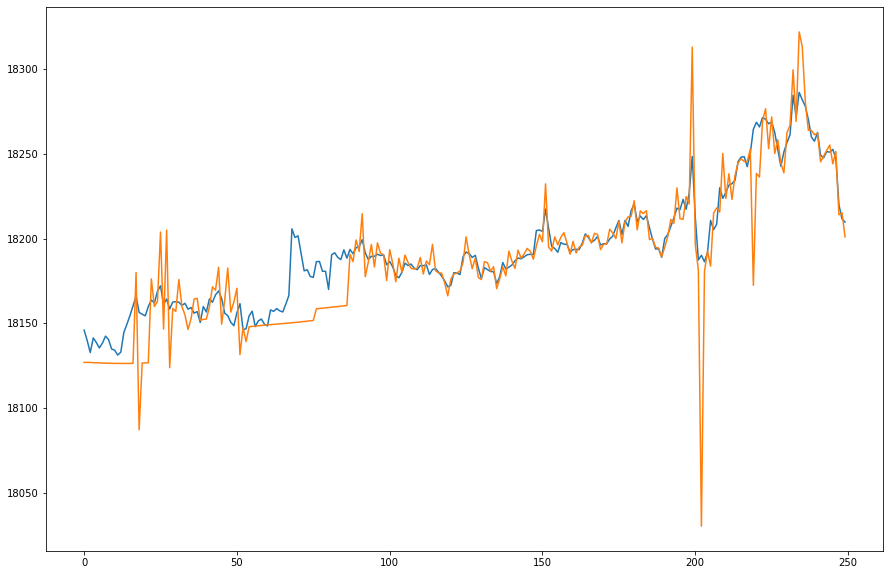

In [117]:
plt.figure(figsize = (15, 10))
plt.plot(list_y)
plt.plot(list_ypred)

In [127]:
m, m2

(6.111240022371385, 0.033546381207092864)

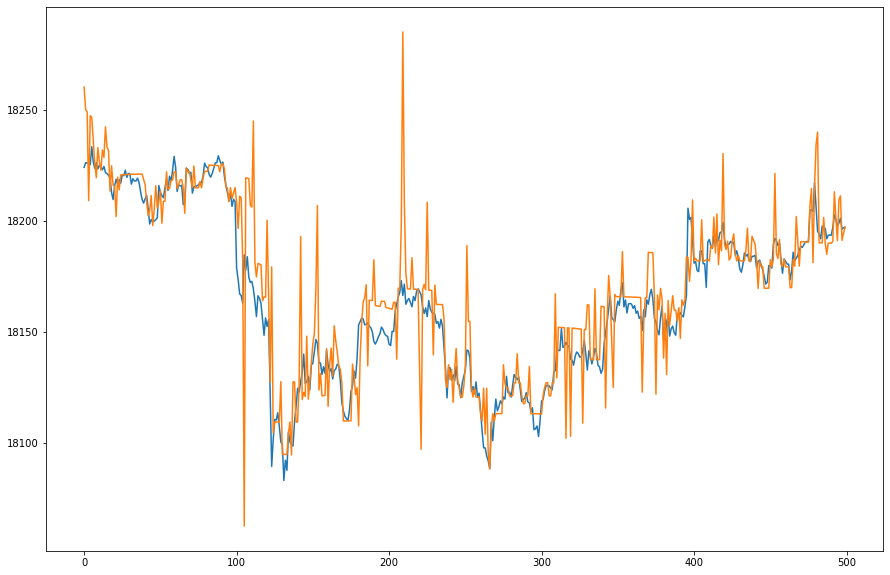

In [17]:
plt.figure(figsize = (15, 10))
plt.plot(list_y)
plt.plot(list_ypred)


In [18]:
m, m2

(3.5350216974168136, 0.019434239081608122)

In [204]:
model = (
            river.preprocessing.StandardScaler() |
            river.tree.HoeffdingTreeRegressor(
                grace_period=200,
                leaf_prediction='adaptive',
                model_selector_decay=0.1
            )
        )

In [205]:
list_y = []
list_ypred = []
for i in range(250):
    y = df[i:100+i].close
    X = df[i:100+i].drop(columns = 'close')
    y, y_pred, m, m2 = evaluate(stream=iter_pandas(X=X, y=y),
                      model=model)
    list_y.append(y)
    list_ypred.append(y_pred)

Samples processed: 99
Prevision at 999
Predicted value : 18127.01
Real value : 18146.06
total train time: 0.027040958404541016
total testing time: 0.004586696624755859
Samples processed: 99
Prevision at 999
Predicted value : 18127.05
Real value : 18140.0
total train time: 0.07319831848144531
total testing time: 0.004935503005981445
Samples processed: 99
Prevision at 999
Predicted value : 18126.98
Real value : 18132.82
total train time: 0.027122020721435547
total testing time: 0.004516124725341797
Samples processed: 99
Prevision at 999
Predicted value : 18126.87
Real value : 18141.48
total train time: 0.06699037551879883
total testing time: 0.004292011260986328
Samples processed: 99
Prevision at 999
Predicted value : 18126.80
Real value : 18138.75
total train time: 0.02958059310913086
total testing time: 0.004599332809448242
Samples processed: 99
Prevision at 999
Predicted value : 18126.73
Real value : 18135.56
total train time: 0.06555604934692383
total testing time: 0.0044550895690917

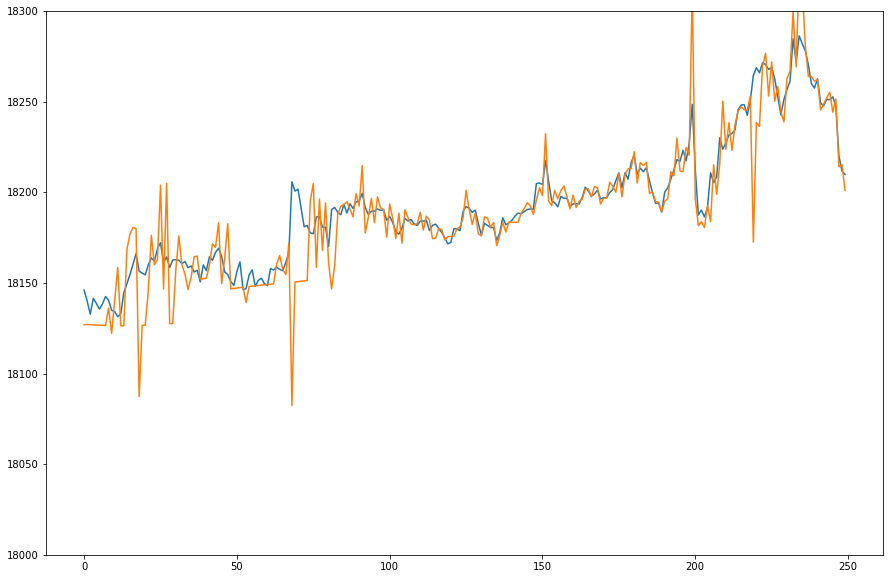

In [206]:
plt.figure(figsize = (15, 10))
plt.ylim([18000, 18300])
plt.plot(list_y)
plt.plot(list_ypred)

In [207]:
m, m2

(6.2435950506481825, 0.0342730414879983)

In [198]:
model = (
            river.preprocessing.StandardScaler() |
            river.tree.HoeffdingTreeRegressor(
                grace_period=200,
                leaf_prediction='adaptive',
                model_selector_decay=2
            )
        )

In [199]:
list_y = []
list_ypred = []
for i in range(250):
    y = df[i:100+i].close
    X = df[i:100+i].drop(columns = 'close')
    y, y_pred, m, m2 = evaluate(stream=iter_pandas(X=X, y=y),
                      model=model)
    list_y.append(y)
    list_ypred.append(y_pred)

Samples processed: 99
Prevision at 999
Predicted value : 18127.01
Real value : 18146.06
total train time: 0.03600358963012695
total testing time: 0.006109952926635742
Samples processed: 99
Prevision at 999
Predicted value : 18127.05
Real value : 18140.0
total train time: 0.07365632057189941
total testing time: 0.004614591598510742
Samples processed: 99
Prevision at 999
Predicted value : 18126.98
Real value : 18132.82
total train time: 0.03969550132751465
total testing time: 0.005989789962768555
Samples processed: 99
Prevision at 999
Predicted value : 18126.87
Real value : 18141.48
total train time: 0.06983828544616699
total testing time: 0.00426936149597168
Samples processed: 99
Prevision at 999
Predicted value : 18126.80
Real value : 18138.75
total train time: 0.03096628189086914
total testing time: 0.005067348480224609
Samples processed: 99
Prevision at 999
Predicted value : 18126.73
Real value : 18135.56
total train time: 0.07105827331542969
total testing time: 0.004750251770019531


/Users/pierreloviton/opt/anaconda3/lib/python3.9/site-packages/river/tree/nodes/htr_nodes.py:179: RuntimeWarning: overflow encountered in double_scalars
  self._fmse_model = tree.model_selector_decay * self._fmse_model + (y - pred_model) ** 2
/Users/pierreloviton/opt/anaconda3/lib/python3.9/site-packages/river/tree/nodes/htr_nodes.py:178: RuntimeWarning: overflow encountered in double_scalars
  self._fmse_mean = tree.model_selector_decay * self._fmse_mean + (y - pred_mean) ** 2


Samples processed: 99
Prevision at 999
Predicted value : 18128.84
Real value : 18144.7
total train time: 0.06716537475585938
total testing time: 0.0050618648529052734
Samples processed: 99
Prevision at 999
Predicted value : 18168.45
Real value : 18149.56
total train time: 0.027487516403198242
total testing time: 0.005270719528198242
Samples processed: 99
Prevision at 999
Predicted value : 18176.96
Real value : 18154.64
total train time: 0.06872010231018066
total testing time: 0.0047991275787353516
Samples processed: 99
Prevision at 999
Predicted value : 18180.68
Real value : 18160.31
total train time: 0.02639150619506836
total testing time: 0.004910469055175781
Samples processed: 99
Prevision at 999
Predicted value : 18180.05
Real value : 18166.21
total train time: 0.07095718383789062
total testing time: 0.0048563480377197266
Samples processed: 99
Prevision at 999
Predicted value : 18087.28
Real value : 18156.54
total train time: 0.02924203872680664
total testing time: 0.00534009933471

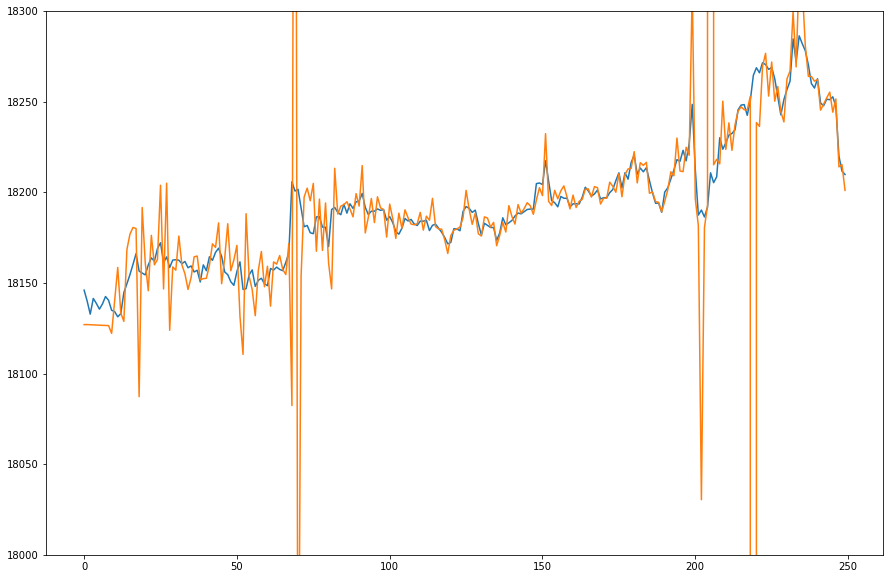

In [202]:
plt.figure(figsize = (15, 10))
plt.ylim([18000, 18300])
plt.plot(list_y)
plt.plot(list_ypred)

In [203]:
m, m2

(32748866116.59499, 8.020027733730178)

In [212]:
model = (
            river.preprocessing.StandardScaler() |
            river.tree.HoeffdingTreeRegressor(
                grace_period=10,
                leaf_prediction='adaptive',
                model_selector_decay=0.9
            )
        )

In [213]:
list_y = []
list_ypred = []
for i in range(250):
    y = df[i:100+i].close
    X = df[i:100+i].drop(columns = 'close')
    y, y_pred, m, m2 = evaluate(stream=iter_pandas(X=X, y=y),
                      model=model)
    list_y.append(y)
    list_ypred.append(y_pred)

Samples processed: 99
Prevision at 999
Predicted value : 18124.59
Real value : 18146.06
total train time: 0.22876524925231934
total testing time: 0.004457235336303711
Samples processed: 99
Prevision at 999
Predicted value : 18126.45
Real value : 18140.0
total train time: 0.15267109870910645
total testing time: 0.004896402359008789
Samples processed: 99
Prevision at 999
Predicted value : 18127.74
Real value : 18132.82
total train time: 0.18395113945007324
total testing time: 0.00521397590637207
Samples processed: 99
Prevision at 999
Predicted value : 18128.67
Real value : 18141.48
total train time: 0.16677355766296387
total testing time: 0.004740238189697266
Samples processed: 99
Prevision at 999
Predicted value : 18129.53
Real value : 18138.75
total train time: 0.16889142990112305
total testing time: 0.0047643184661865234
Samples processed: 99
Prevision at 999
Predicted value : 18130.32
Real value : 18135.56
total train time: 0.16582894325256348
total testing time: 0.004579067230224609

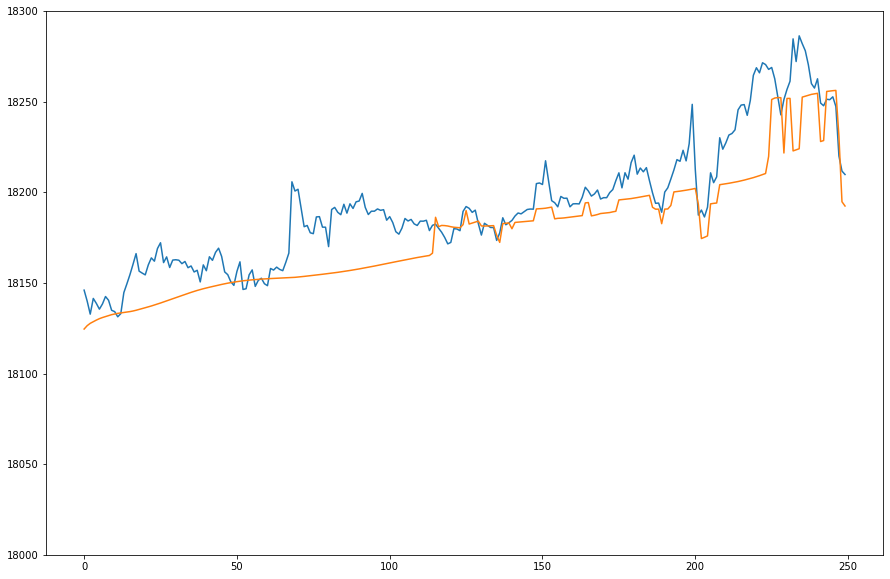

In [214]:
plt.figure(figsize = (15, 10))
plt.ylim([18000, 18300])
plt.plot(list_y)
plt.plot(list_ypred)

In [215]:
m, m2

(11.985337491365426, 0.06574979617678825)

In [208]:
model = (
            river.preprocessing.StandardScaler() |
            river.tree.HoeffdingTreeRegressor(
                grace_period=100,
                leaf_prediction='adaptive',
                model_selector_decay=0.9
            )
        )

In [209]:
list_y = []
list_ypred = []
for i in range(250):
    y = df[i:100+i].close
    X = df[i:100+i].drop(columns = 'close')
    y, y_pred, m, m2 = evaluate(stream=iter_pandas(X=X, y=y),
                      model=model)
    list_y.append(y)
    list_ypred.append(y_pred)

Samples processed: 99
Prevision at 999
Predicted value : 18127.01
Real value : 18146.06
total train time: 0.06345820426940918
total testing time: 0.005671977996826172
Samples processed: 99
Prevision at 999
Predicted value : 18127.05
Real value : 18140.0
total train time: 0.06930255889892578
total testing time: 0.004370689392089844
Samples processed: 99
Prevision at 999
Predicted value : 18126.98
Real value : 18132.82
total train time: 0.06256723403930664
total testing time: 0.004329681396484375
Samples processed: 99
Prevision at 999
Predicted value : 18126.87
Real value : 18141.48
total train time: 0.06547713279724121
total testing time: 0.004768848419189453
Samples processed: 99
Prevision at 999
Predicted value : 18126.80
Real value : 18138.75
total train time: 0.06669497489929199
total testing time: 0.004069805145263672
Samples processed: 99
Prevision at 999
Predicted value : 18126.73
Real value : 18135.56
total train time: 0.07637166976928711
total testing time: 0.004930734634399414

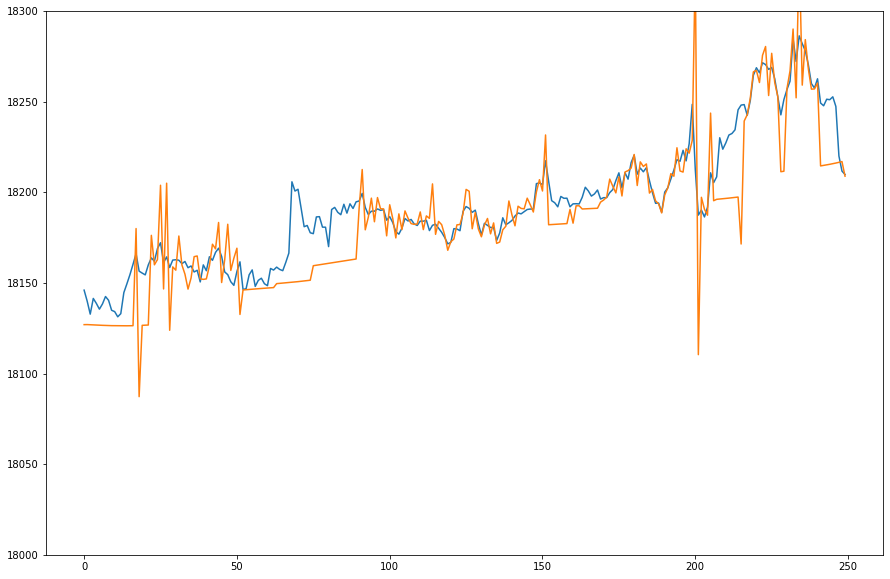

In [210]:
plt.figure(figsize = (15, 10))
plt.ylim([18000, 18300])
plt.plot(list_y)
plt.plot(list_ypred)

In [211]:
m, m2

(12.099897521185268, 0.06637331391719749)

In [128]:
model = (
     river.preprocessing.StandardScaler() |
     river.tree.HoeffdingAdaptiveTreeRegressor(
         grace_period=20,
         leaf_prediction='adaptive',
         model_selector_decay=0.3,
         seed=0
     ))

In [129]:
list_y = []
list_ypred = []
for i in range(250):
    y = df[i:100+i].close
    X = df[i:100+i].drop(columns = 'close')
    y, y_pred, m, m2 = evaluate(stream=iter_pandas(X=X, y=y),
                      model=model)
    list_y.append(y)
    list_ypred.append(y_pred)

Samples processed: 99
Prevision at 2023-01-12 13:24:00
Predicted value : 18122.45
Real value : 18146.06
total train time: 0.6142137050628662
total testing time: 0.0066683292388916016
Samples processed: 99
Prevision at 2023-01-12 13:24:00
Predicted value : 18125.16
Real value : 18140.0
total train time: 0.15791606903076172
total testing time: 0.006511688232421875
Samples processed: 99
Prevision at 2023-01-12 13:24:00
Predicted value : 18126.42
Real value : 18132.82
total train time: 0.16399669647216797
total testing time: 0.006226778030395508
Samples processed: 99
Prevision at 2023-01-12 13:24:00
Predicted value : 18127.17
Real value : 18141.48
total train time: 0.15679550170898438
total testing time: 0.00596928596496582
Samples processed: 99
Prevision at 2023-01-12 13:24:00
Predicted value : 18128.28
Real value : 18138.75
total train time: 0.14282751083374023
total testing time: 0.005623340606689453
Samples processed: 99
Prevision at 2023-01-12 13:24:00
Predicted value : 18129.20
Real 

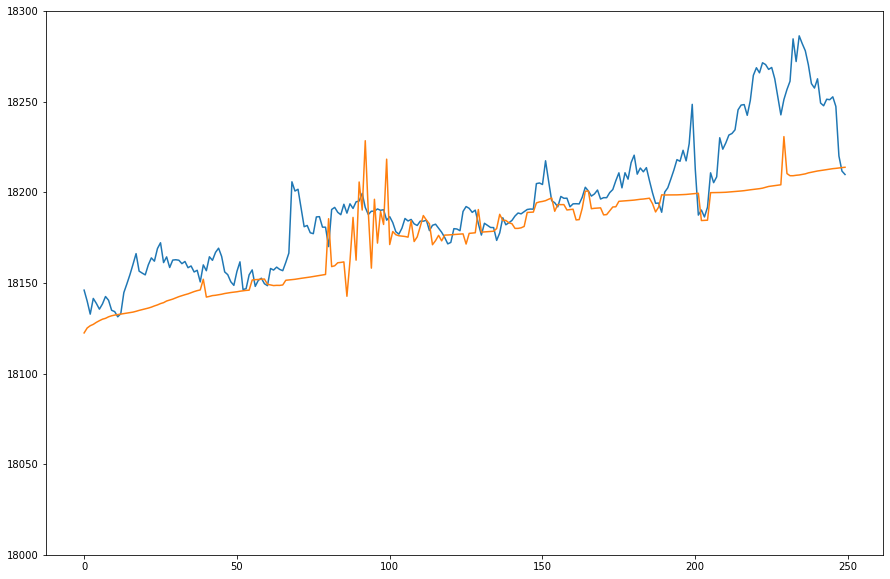

In [130]:
plt.figure(figsize = (15, 10))
plt.ylim([18000, 18300])
plt.plot(list_y)
plt.plot(list_ypred)

In [131]:
m, m2

(16.457090913922325, 0.09026269871864168)

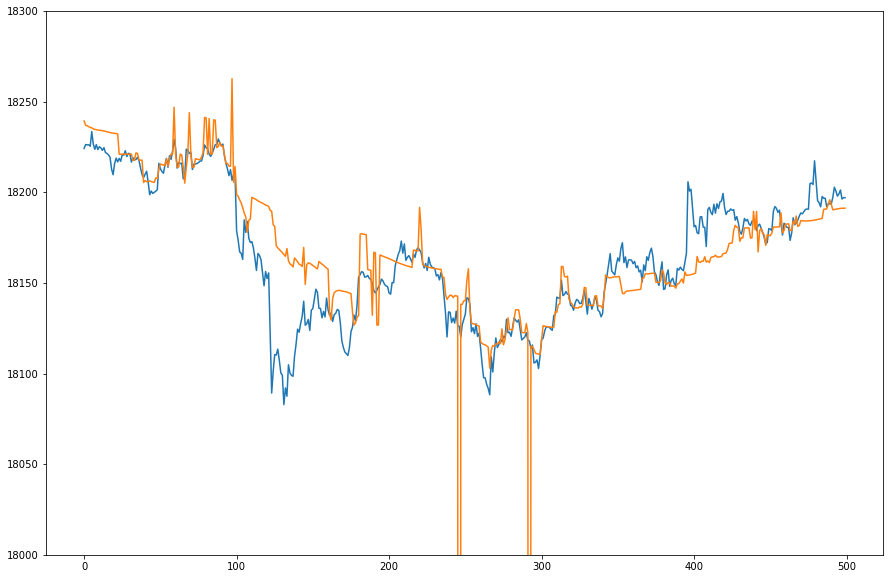

In [97]:
plt.figure(figsize = (15, 10))
plt.ylim([18000, 18300])
plt.plot(list_y)
plt.plot(list_ypred)

In [94]:
m, m2

(3.2398646997080136, 0.01781325382959503)

In [217]:
model = (
     river.preprocessing.StandardScaler() |
     river.tree.HoeffdingAdaptiveTreeRegressor(
         grace_period=20,
         leaf_prediction='adaptive',
         model_selector_decay=0.9,
         seed=0
     ))

In [218]:
list_y = []
list_ypred = []
for i in range(250):
    y = df[i:100+i].close
    X = df[i:100+i].drop(columns = 'close')
    y, y_pred, m, m2 = evaluate(stream=iter_pandas(X=X, y=y),
                      model=model)
    list_y.append(y)
    list_ypred.append(y_pred)

Samples processed: 99
Prevision at 999
Predicted value : 18122.45
Real value : 18146.06
total train time: 0.1093759536743164
total testing time: 0.0057697296142578125
Samples processed: 99
Prevision at 999
Predicted value : 18125.16
Real value : 18140.0
total train time: 0.12966394424438477
total testing time: 0.005469560623168945
Samples processed: 99
Prevision at 999
Predicted value : 18126.42
Real value : 18132.82
total train time: 0.1500091552734375
total testing time: 0.0053446292877197266
Samples processed: 99
Prevision at 999
Predicted value : 18127.17
Real value : 18141.48
total train time: 0.15734505653381348
total testing time: 0.005388498306274414
Samples processed: 99
Prevision at 999
Predicted value : 18128.28
Real value : 18138.75
total train time: 0.14311528205871582
total testing time: 0.00580906867980957
Samples processed: 99
Prevision at 999
Predicted value : 18129.20
Real value : 18135.56
total train time: 0.15378737449645996
total testing time: 0.005868196487426758


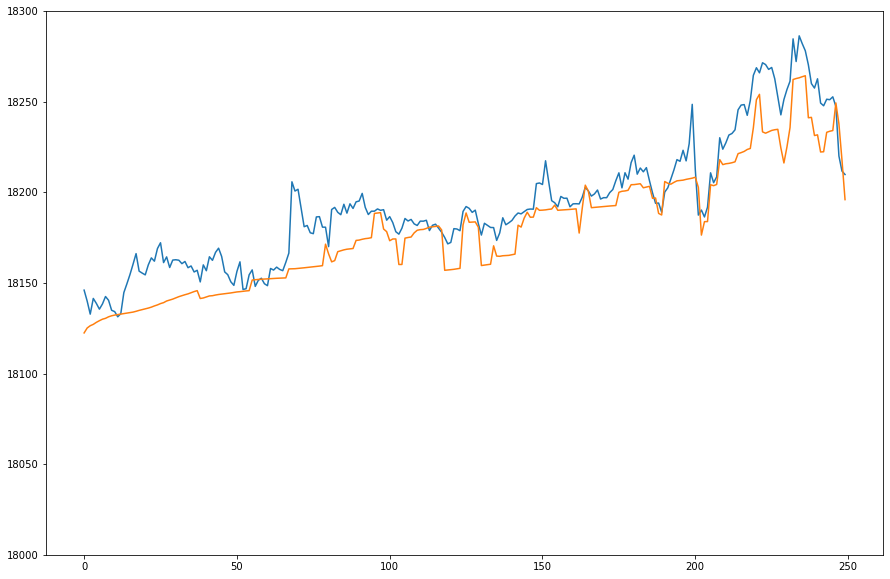

In [219]:
plt.figure(figsize = (15, 10))
plt.ylim([18000, 18300])
plt.plot(list_y)
plt.plot(list_ypred)

In [220]:
m, m2

(8.90412723802696, 0.048837892084581155)

In [221]:
model = (
     river.preprocessing.StandardScaler() |
     river.tree.HoeffdingAdaptiveTreeRegressor(
         grace_period=100,
         leaf_prediction='adaptive',
         model_selector_decay=0.9,
         seed=0
     ))

In [222]:
list_y = []
list_ypred = []
for i in range(250):
    y = df[i:100+i].close
    X = df[i:100+i].drop(columns = 'close')
    y, y_pred, m, m2 = evaluate(stream=iter_pandas(X=X, y=y),
                      model=model)
    list_y.append(y)
    list_ypred.append(y_pred)

Samples processed: 99
Prevision at 999
Predicted value : 18125.60
Real value : 18146.06
total train time: 0.05425095558166504
total testing time: 0.0055391788482666016
Samples processed: 99
Prevision at 999
Predicted value : 18126.85
Real value : 18140.0
total train time: 0.0682229995727539
total testing time: 0.0045621395111083984
Samples processed: 99
Prevision at 999
Predicted value : 18126.76
Real value : 18132.82
total train time: 0.09511399269104004
total testing time: 0.004607677459716797
Samples processed: 99
Prevision at 999
Predicted value : 18126.56
Real value : 18141.48
total train time: 0.06719660758972168
total testing time: 0.00439453125
Samples processed: 99
Prevision at 999
Predicted value : 18126.81
Real value : 18138.75
total train time: 0.06438064575195312
total testing time: 0.0044481754302978516
Samples processed: 99
Prevision at 999
Predicted value : 18126.63
Real value : 18135.56
total train time: 0.09386324882507324
total testing time: 0.00455784797668457
Sampl

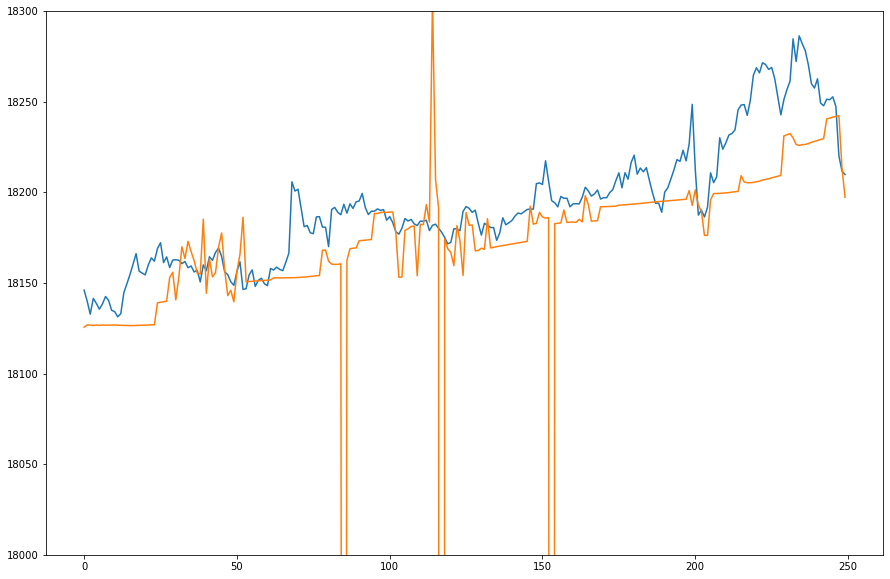

In [223]:
plt.figure(figsize = (15, 10))
plt.ylim([18000, 18300])
plt.plot(list_y)
plt.plot(list_ypred)

In [224]:
m, m2

(9.916537002455119, 0.054371354577071186)

In [132]:
import calendar
import math
from river import compose
from river import linear_model
from river import optim
from river import preprocessing

In [181]:
 model = (
     time_series.SNARIMAX(
         p=0,
         d=0,
         q=0,
         m=100,
         sp=100,
         sq=100,
         regressor=(
             preprocessing.StandardScaler() |
             linear_model.LinearRegression(
                 intercept_init=110,
                 optimizer=optim.SGD(0.01),
                 intercept_lr=0.3
             )
         )
     
 ))

In [175]:
def evaluate_SNARIMAX(model, h, Y_t, n_iter):
    preds = []
    metric = river.metrics.MAE()
    metric_mape = river.metrics.SMAPE()
    for i in range(n_iter):
        
        y_pred = model.forecast(horizon=50)
        preds.append(y_pred[h-1])
        
        model = model.learn_one(Y_t[i])
        if i > 10:
            m = metric.update(y_pred[h-1], Y_t[i + h]).get()
            m2 = metric_mape.update(y_pred[h-1], Y_t[i + h]).get()

    return metric, metric_mape, preds

In [76]:
list_ypred, m, m2

(MAE: 11.393609,
 SMAPE: 0.062703,
 [18193.379446169354,
  18232.14312123402,
  18249.35666701104,
  18249.840533444498,
  18244.875838285043,
  18260.25048179773,
  18261.15062937932,
  18253.00030294319,
  18254.186145052878,
  18253.39365328204,
  18244.959706287667,
  18246.26307010555,
  18248.523726814296,
  18248.36676999225,
  18249.65177970652,
  18248.6043888586,
  18249.752153882007,
  18246.255894753187,
  18246.419890261135,
  18245.14467096361,
  18244.6038613238,
  18240.75969369909,
  18240.599559179173,
  18243.52393401849,
  18243.913137625983,
  18244.429318092178,
  18239.630404158233,
  18241.985355057594,
  18246.019710102682,
  18242.35923720083,
  18235.227759508194,
  18240.32937330199,
  18246.779492105634,
  18243.37745259362,
  18254.742633007845,
  18266.54721811314,
  18278.347218145933,
  18273.002099344896,
  18269.599592945255,
  18272.526747580327,
  18276.653034530656,
  18285.160142352855,
  18294.06789527369,
  18253.046811830274,
  18258.5162202961

In [186]:
h=5
Y_t = df['close'].values
n_iter = 345
m, m2, list_ypred = evaluate_SNARIMAX(model, h, Y_t, n_iter)

In [190]:
Y_t.shape

(350,)

In [192]:
len(list_ypred)

345

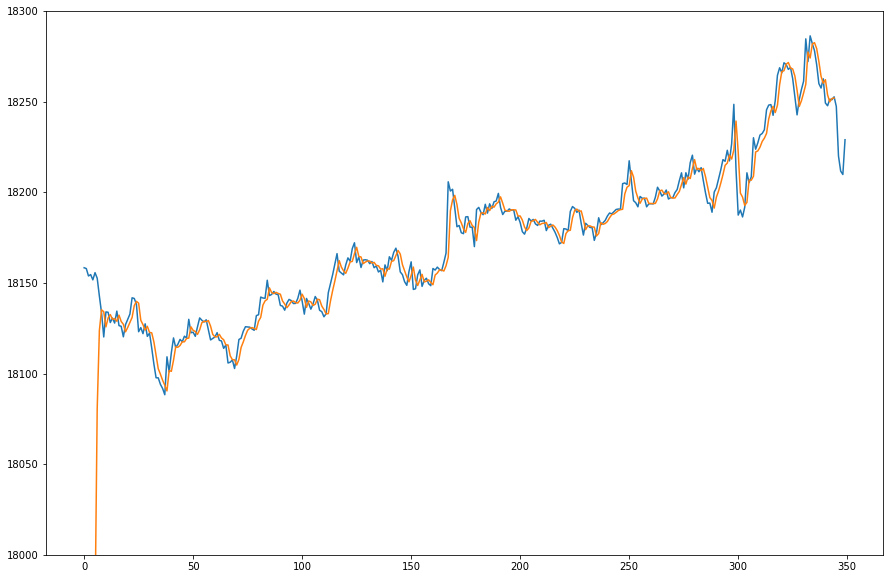

In [137]:
plt.figure(figsize = (15, 10))
plt.ylim([18000, 18300])
plt.plot(Y_t)
plt.plot(list_ypred)

In [138]:
m, m2

(MAE: 11.554451, SMAPE: 0.063539)

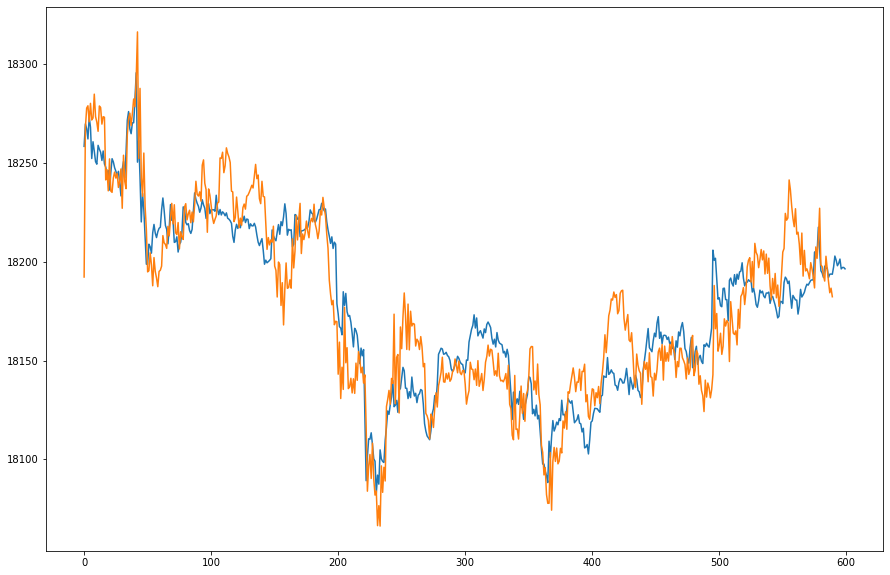

In [89]:
plt.figure(figsize = (15, 10))
#plt.ylim([18000, 18300])
plt.plot(Y_t)
plt.plot(list_ypred)

In [87]:
m, m2

(MAE: 9.862411, SMAPE: 0.054268)